### **ENVIRONMENT SETUP**

In [1]:
# %cd /content/
# ! rm -rf google-research/
# ! pip install -q beautifulsoup4 emoji numpy pandas transformers torch lxml requests bs4
# ! git clone https://github.com/google-research/google-research.git
# %cd google-research/goemotions

### **IMPORT LIBRARIES**

In [78]:
import os
import re
import string
import json
import emoji
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)

from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import tensorflow as tf
import tensorflow.keras as keras
import pickle

#### **LOAD DATASET**

In [4]:
# Load the testing and validations datasets

df_train = pd.read_csv("data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
df_dev = pd.read_csv("data/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [5]:
df_train.head()

,Text,Class,ID
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [6]:
# Obtain the Class List and Number of Classes

df_train['List of classes'] = df_train['Class'].apply(lambda x: x.split(','))
df_train['Len of classes'] = df_train['List of classes'].apply(lambda x: len(x))

df_dev['List of classes'] = df_dev['Class'].apply(lambda x: x.split(','))
df_dev['Len of classes'] = df_dev['List of classes'].apply(lambda x: len(x))

In [7]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1
3,To make her feel threatened,14,ed7ypvh,[14],1
4,Dirty Southern Wankers,3,ed0bdzj,[3],1


In [8]:
# Load the ekman mapping

with open('data/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)
    
ekman_mapping

{'anger': ['anger', 'annoyance', 'disapproval'],
 'disgust': ['disgust'],
 'fear': ['fear', 'nervousness'],
 'joy': ['joy',
  'amusement',
  'approval',
  'excitement',
  'gratitude',
  'love',
  'optimism',
  'relief',
  'pride',
  'admiration',
  'desire',
  'caring'],
 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'],
 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}

In [9]:
# Load the list of original emotions

emotion_file = open("data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)
print(f"Number of Original Emotions = {len(emotion_list)}")

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
Number of Original Emotions = 28


In [10]:
# Define function to convert class number to emotion

def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [11]:
df_train['Emotions'] = df_train['List of classes'].apply(idx2class)
df_dev['Emotions'] = df_dev['List of classes'].apply(idx2class)

In [12]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes,Emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance]


In [13]:
# Define function to map the emotions according to the ekman mapping

def EmotionMapping(emotion_list):
    map_list = []
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
    return map_list

In [14]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)
df_dev['Mapped Emotions'] = df_dev['Emotions'].apply(EmotionMapping)

In [15]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral]
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger]
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear]
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger]


In [16]:
# Create columns for the new mapped emotions

df_train['anger'] = np.zeros((len(df_train),1))
df_train['disgust'] = np.zeros((len(df_train),1))
df_train['fear'] = np.zeros((len(df_train),1))
df_train['joy'] = np.zeros((len(df_train),1))
df_train['sadness'] = np.zeros((len(df_train),1))
df_train['surprise'] = np.zeros((len(df_train),1))
df_train['neutral'] = np.zeros((len(df_train),1))

df_dev['anger'] = np.zeros((len(df_dev),1))
df_dev['disgust'] = np.zeros((len(df_dev),1))
df_dev['fear'] = np.zeros((len(df_dev),1))
df_dev['joy'] = np.zeros((len(df_dev),1))
df_dev['sadness'] = np.zeros((len(df_dev),1))
df_dev['surprise'] = np.zeros((len(df_dev),1))
df_dev['neutral'] = np.zeros((len(df_dev),1))

# Fill the column with the corresponding emotions
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    df_train[i] = df_train['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    df_dev[i] = df_dev['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [17]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger],1,0,0,0,0,0,0


In [18]:
df_dev.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,Is this in New Orleans?? I really feel like th...,27,edgurhb,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"You know the answer man, you are programmed to...","4,27",ee84bjg,"[4, 27]",2,"[approval, neutral]","[joy, neutral]",0,0,0,1,0,0,1
2,I've never been this sad in my life!,25,edcu99z,[25],1,[sadness],[sadness],0,0,0,0,1,0,0
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2,"[4, 27]",2,"[approval, neutral]","[joy, neutral]",0,0,0,1,0,0,1
4,He could have easily taken a real camera from ...,20,eepig6r,[20],1,[optimism],[joy],0,0,0,1,0,0,0


In [19]:
# Drop Neutral and Disgust emotions

df_train.drop(df_train[df_train['neutral'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['neutral'] == 1].index, inplace=True)

df_train.drop(df_train[df_train['disgust'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['disgust'] == 1].index, inplace=True)

In [20]:
# Drop extra columns

df_train.drop(['Class', 'List of classes', 'Len of classes', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)
df_dev.drop(['Class', 'List of classes', 'Len of classes', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)

In [21]:
df_train.head()

,Text,ID,anger,fear,joy,sadness,surprise
2,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0
3,To make her feel threatened,ed7ypvh,0,1,0,0,0
4,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1
6,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,1,0,0


### **DATA PREPROCESSING**

In [22]:
# Mapping for expansion of contracted words

contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
    "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
    "might've": "might have","mightn't": "might not", "mightn't've": "might not have", "must've": "must have", 
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
    "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 
    'e.g':'for example'
}

# Function to expand the contractions

def clean_contractions(text, mapping):
    # Uniform apostrophe
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
        
    # Expand the words using mapping
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
            
    # Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Create space b/w word and punctuation following it
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

In [23]:
# List of punctuations

punct = [
    ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',
    '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
    '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
    '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', 
    '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', 
    '‡', '√', 
]

# Mapping for punctuations

punct_mapping = {
    "‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
    "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
    'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '
}

In [24]:
# Dictionary to correct the misspellings

mispell_dict = {
    'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 
    'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 
    'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 
    'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 
    'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', 
    "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', 
    '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 
    'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'
}

# Function to correct the misspellings

def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [25]:
# Function to clean the text

def clean_text(text):
    text = emoji.demojize(text) # Remove emojis
    text = re.sub(r'\:(.*?)\:','',text) 
    text = str(text).lower() # Make text lowercase
    text = re.sub('\[.*?\]', '', text) # Remove text inside square brackets
    text = BeautifulSoup(text, 'lxml').get_text() # Remove html
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove links
    text = re.sub('<.*?>+', '', text) # Remove text inside angular brackets
    text = re.sub('\n', '', text) # Remove newlines
    text = re.sub('\w*\d\w*', '', text) # Remove words that contain numbers
    # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

In [26]:
# Function to remove any special characters

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    for p in punct:
        text = text.replace(p, f' {p} ')
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''} # List of special characters
    for s in specials:
        text = text.replace(s, specials[s])
    return text

# Function to remove any extra spaces

def remove_space(text):
    text = text.strip()
    text = text.split()
    return " ".join(text)

In [27]:
# Function to perform the entire preprocessing

def text_preprocessing_pipeline(text):
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [28]:
# Apply preprocessing

df_train['Text'] = df_train['Text'].apply(text_preprocessing_pipeline)
df_dev['Text'] = df_dev['Text'].apply(text_preprocessing_pipeline)

In [29]:
# Reset the Indices

df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)

In [30]:
df_train.head()

,Text,ID,anger,fear,joy,sadness,surprise
0,why the fuck is bayless isoing,eezlygj,1,0,0,0,0
1,to make her feel threatened,ed7ypvh,0,1,0,0,0
2,dirty southern wankers,ed0bdzj,1,0,0,0,0
3,omg peyton is not good enough to help us in th...,edvnz26,0,0,0,0,1
4,yes i heard abt the f bombs that has to be why...,ee3b6wu,0,0,1,0,0


In [31]:
df_dev.head()

,Text,ID,anger,fear,joy,sadness,surprise
0,i have never been this sad in my life,edcu99z,0,0,0,1,0
1,he could have easily taken a real camera from ...,eepig6r,0,0,1,0,0
2,thank you for your vote of confidence but we s...,eczm50f,0,0,1,0,0
3,wah mum other people call me on my bullshit an...,ed4yr9r,1,0,0,0,0
4,at least now has more time to gain his confidence,eekez9p,0,0,1,0,0


In [32]:
print(df_train.shape)
print(df_dev.shape)

(28427, 7)
(3564, 7)


### **FEATURE EXTRACTION USING PRE-TRAINED BERT**

In [34]:
# Load Transformer Model

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
# Sample Output

tokenized_input = tokenizer(
        df_train["Text"][0],
        padding=True,
        truncation=False,
        return_tensors='pt'
    )

sample_output = model(**tokenized_input)

In [36]:
print(f"Shape of sample output = {sample_output.pooler_output.cpu().detach().numpy().shape}")

Shape of sample output = (1, 768)


In [40]:
# Tokenizing Training Data

input = []

for text in df_train["Text"]:
    tokenized_input = tokenizer(
        text,
        padding=True,
        truncation=False,
        return_tensors='pt'
    )
    input.append(tokenized_input)

In [41]:
# Embedding the Training Data

output = []

j = 1

for i in range(len(input)):
    
    model_output = model(**input[i])
    model_output = model_output.pooler_output.cpu().detach().numpy()
    output.append(model_output)
    
    # Saving Embedded Input Data to Disk

    if ((i + 1) % 400) == 0:
        
        file_name = "./embed-train-data/output" + str(j) + ".pickle"
        
        with open(file_name, "wb") as fp:   
            # Pickling
            pickle.dump(output, fp)
        
        print(file_name + " done")
        output = []
        j += 1
        
file_name = "./embed-train-data/output" + str(j) + ".pickle"

with open(file_name, "wb") as fp:   
    # Pickling
    pickle.dump(output, fp)

print(file_name + " done")
output = []

./embed-train-data/output1.pickle done
./embed-train-data/output2.pickle done
./embed-train-data/output3.pickle done
./embed-train-data/output4.pickle done
./embed-train-data/output5.pickle done
./embed-train-data/output6.pickle done
./embed-train-data/output7.pickle done
./embed-train-data/output8.pickle done
./embed-train-data/output9.pickle done
./embed-train-data/output10.pickle done
./embed-train-data/output11.pickle done
./embed-train-data/output12.pickle done
./embed-train-data/output13.pickle done
./embed-train-data/output14.pickle done
./embed-train-data/output15.pickle done
./embed-train-data/output16.pickle done
./embed-train-data/output17.pickle done
./embed-train-data/output18.pickle done
./embed-train-data/output19.pickle done
./embed-train-data/output20.pickle done
./embed-train-data/output21.pickle done
./embed-train-data/output22.pickle done
./embed-train-data/output23.pickle done
./embed-train-data/output24.pickle done
./embed-train-data/output25.pickle done
./embed-t

In [42]:
# Tokenizing Validation Data

input = []

for text in df_dev["Text"]:
    tokenized_input = tokenizer(
        text,
        padding=True,
        truncation=False,
        return_tensors='pt'
    )
    input.append(tokenized_input)

In [43]:
# Embedding the Validation Data

output = []

j = 1

for i in range(len(input)):
    
    model_output = model(**input[i])
    model_output = model_output.pooler_output.cpu().detach().numpy()
    output.append(model_output)
    
    # Saving Embedded Input Data to Disk

    if ((i + 1) % 400) == 0:
        
        file_name = "./embed-val-data/output" + str(j) + ".pickle"
        
        with open(file_name, "wb") as fp:   
            # Pickling
            pickle.dump(output, fp)
        
        print(file_name + " done")
        output = []
        j += 1
        
file_name = "./embed-val-data/output" + str(j) + ".pickle"

with open(file_name, "wb") as fp:   
    # Pickling
    pickle.dump(output, fp)

print(file_name + " done")
output = []

./embed-val-data/output1.pickle done
./embed-val-data/output2.pickle done
./embed-val-data/output3.pickle done
./embed-val-data/output4.pickle done
./embed-val-data/output5.pickle done
./embed-val-data/output6.pickle done
./embed-val-data/output7.pickle done
./embed-val-data/output8.pickle done
./embed-val-data/output9.pickle done


In [37]:
# Loading Embedded Training Data from Disk

output = []

num_files = len(os.listdir("./embed-train-data/"))

for i in range(num_files):
    file_name = "./embed-train-data/output" + str(i + 1) + ".pickle"
    with open(file_name, "rb") as fp:   #Pickling
        file_output = pickle.load(fp)
        for x in file_output:
            output.append(x)
    # print(file_name + " done")

X_train = output
output = []

In [38]:
# Loading Embedded Validation Data from Disk

output = []

num_files = len(os.listdir("./embed-val-data/"))

for i in range(num_files):
    file_name = "./embed-val-data/output" + str(i + 1) + ".pickle"
    with open(file_name, "rb") as fp:   #Pickling
        file_output = pickle.load(fp)
        for x in file_output:
            output.append(x)
    # print(file_name + " done")

X_val = output
output = []

In [39]:
print(f"Number of training data = {len(X_train)}")
print(f"Number of validation data = {len(X_val)}")

Number of training data = 28427
Number of validation data = 3564


### **TRAIN FULLY CONNECTED LAYER**

In [40]:
X_train = np.array(X_train).reshape(len(X_train), 768)
X_val = np.array(X_val).reshape(len(X_val), 768)

In [41]:
target_labels = [col for col in df_train.columns if col not in ['Text', 'ID']]
target_labels

['anger', 'fear', 'joy', 'sadness', 'surprise']

In [42]:
y_train = df_train[target_labels].values
y_val = df_dev[target_labels].values

In [43]:
print(f"Shape of training labels = {y_train.shape}")
print(f"Shape of validation labels = {y_val.shape}")

Shape of training labels = (28427, 5)
Shape of validation labels = (3564, 5)


In [54]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold
 
    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs["val_loss"]
        if val_loss <= self.threshold:
            self.model.stop_training = True

In [57]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(768, kernel_initializer="normal", activation="relu"))
model.add(keras.layers.Dense(64, kernel_initializer="normal", activation="relu"))
model.add(keras.layers.Dense(5, kernel_initializer="normal", activation="sigmoid"))

loss_fn = keras.losses.BinaryCrossentropy()
optimizer_fn = keras.optimizers.SGD(learning_rate=0.005)

callback = MyThresholdCallback(threshold=0.28)

model.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=["accuracy"])

In [58]:
history = model.fit(X_train, y_train, epochs = 1000, batch_size = 32, 
                    validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.4300 - accuracy: 0.5644 - val_loss: 0.4104 - val_accuracy: 0.5805
Epoch 2/1000
889/889 [==============================] - 3s 4ms/step - loss: 0.4127 - accuracy: 0.5741 - val_loss: 0.4088 - val_accuracy: 0.5805
Epoch 3/1000
889/889 [==============================] - 3s 4ms/step - loss: 0.4109 - accuracy: 0.5741 - val_loss: 0.4068 - val_accuracy: 0.5805
Epoch 4/1000
889/889 [==============================] - 3s 4ms/step - loss: 0.4089 - accuracy: 0.5741 - val_loss: 0.4045 - val_accuracy: 0.5805
Epoch 5/1000
889/889 [==============================] - 3s 4ms/step - loss: 0.4065 - accuracy: 0.5741 - val_loss: 0.4017 - val_accuracy: 0.5805
Epoch 6/1000
889/889 [==============================] - 3s 4ms/step - loss: 0.4036 - accuracy: 0.5741 - val_loss: 0.3983 - val_accuracy: 0.5805
Epoch 7/1000
889/889 [==============================] - 3s 4ms/step - loss: 0.4000 - accuracy: 0.5741 - val_loss: 0.3947 - val_accuracy:

889/889 [==============================] - 3s 4ms/step - loss: 0.3097 - accuracy: 0.6733 - val_loss: 0.3112 - val_accuracy: 0.6776
Epoch 58/1000
889/889 [==============================] - 3s 4ms/step - loss: 0.3095 - accuracy: 0.6757 - val_loss: 0.3128 - val_accuracy: 0.6785
Epoch 59/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.3091 - accuracy: 0.6775 - val_loss: 0.3390 - val_accuracy: 0.6375
Epoch 60/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.3083 - accuracy: 0.6770 - val_loss: 0.3129 - val_accuracy: 0.6804
Epoch 61/1000
889/889 [==============================] - 3s 4ms/step - loss: 0.3075 - accuracy: 0.6778 - val_loss: 0.3167 - val_accuracy: 0.6740
Epoch 62/1000
889/889 [==============================] - 3s 4ms/step - loss: 0.3076 - accuracy: 0.6761 - val_loss: 0.3108 - val_accuracy: 0.6737
Epoch 63/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.3072 - accuracy: 0.6763 - val_loss: 0.3099 - val_accuracy: 0.6756

889/889 [==============================] - 4s 4ms/step - loss: 0.2920 - accuracy: 0.6964 - val_loss: 0.2976 - val_accuracy: 0.6880
Epoch 114/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2922 - accuracy: 0.6957 - val_loss: 0.2945 - val_accuracy: 0.6984
Epoch 115/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2912 - accuracy: 0.6940 - val_loss: 0.2963 - val_accuracy: 0.6942
Epoch 116/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2913 - accuracy: 0.6961 - val_loss: 0.3180 - val_accuracy: 0.6532
Epoch 117/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2913 - accuracy: 0.6976 - val_loss: 0.2952 - val_accuracy: 0.6916
Epoch 118/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2905 - accuracy: 0.6954 - val_loss: 0.2988 - val_accuracy: 0.6894
Epoch 119/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2909 - accuracy: 0.6972 - val_loss: 0.2997 - val_accuracy: 

889/889 [==============================] - 4s 4ms/step - loss: 0.2834 - accuracy: 0.7049 - val_loss: 0.2900 - val_accuracy: 0.6947
Epoch 170/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2837 - accuracy: 0.7044 - val_loss: 0.2909 - val_accuracy: 0.6953
Epoch 171/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2832 - accuracy: 0.7069 - val_loss: 0.2960 - val_accuracy: 0.6869
Epoch 172/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2833 - accuracy: 0.7065 - val_loss: 0.2893 - val_accuracy: 0.6961
Epoch 173/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2829 - accuracy: 0.7062 - val_loss: 0.3106 - val_accuracy: 0.6796
Epoch 174/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2834 - accuracy: 0.7055 - val_loss: 0.3337 - val_accuracy: 0.6263
Epoch 175/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2826 - accuracy: 0.7062 - val_loss: 0.3579 - val_accuracy: 

889/889 [==============================] - 4s 4ms/step - loss: 0.2779 - accuracy: 0.7112 - val_loss: 0.2892 - val_accuracy: 0.6995
Epoch 226/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2769 - accuracy: 0.7126 - val_loss: 0.2927 - val_accuracy: 0.6908
Epoch 227/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2771 - accuracy: 0.7128 - val_loss: 0.2874 - val_accuracy: 0.6992
Epoch 228/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2769 - accuracy: 0.7139 - val_loss: 0.2905 - val_accuracy: 0.6880
Epoch 229/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2767 - accuracy: 0.7125 - val_loss: 0.2949 - val_accuracy: 0.6821
Epoch 230/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2764 - accuracy: 0.7130 - val_loss: 0.2889 - val_accuracy: 0.7009
Epoch 231/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2773 - accuracy: 0.7112 - val_loss: 0.3050 - val_accuracy: 

889/889 [==============================] - 4s 4ms/step - loss: 0.2724 - accuracy: 0.7158 - val_loss: 0.2935 - val_accuracy: 0.6871
Epoch 282/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2714 - accuracy: 0.7186 - val_loss: 0.2819 - val_accuracy: 0.7001
Epoch 283/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2716 - accuracy: 0.7172 - val_loss: 0.2830 - val_accuracy: 0.7026
Epoch 284/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2715 - accuracy: 0.7187 - val_loss: 0.2948 - val_accuracy: 0.6874
Epoch 285/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2718 - accuracy: 0.7192 - val_loss: 0.2838 - val_accuracy: 0.6981
Epoch 286/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2716 - accuracy: 0.7179 - val_loss: 0.2984 - val_accuracy: 0.6751
Epoch 287/1000
889/889 [==============================] - 4s 4ms/step - loss: 0.2716 - accuracy: 0.7162 - val_loss: 0.2859 - val_accuracy: 

### **VALIDATE MODEL**

In [70]:
y_pred = model.predict(X_val)
y_pred = [np.argmax(x) for x in y_pred]

y_val_new = [np.argmax(x) for x in y_val]

112/112 [==============================] - 0s 2ms/step


In [73]:
print(metrics.classification_report(y_val_new, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59       660
           1       0.00      0.00      0.00        92
           2       0.79      0.89      0.83      2069
           3       0.49      0.33      0.39       284
           4       0.56      0.40      0.47       459

    accuracy                           0.71      3564
   macro avg       0.48      0.44      0.46      3564
weighted avg       0.67      0.71      0.68      3564



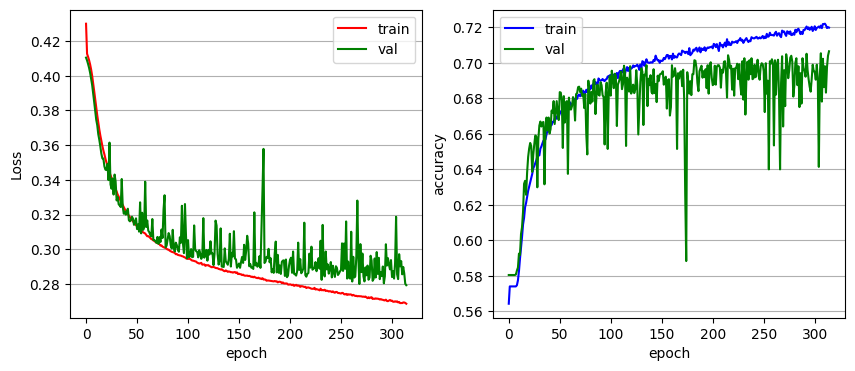

In [77]:
figure= plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax.plot(history.history['loss'], 'r', label='train')
ax.plot(history.history['val_loss'], 'g', label='val')

plt.legend()
plt.grid(axis='y')
plt.xlabel("epoch")
plt.ylabel("Loss")

ax2 = plt.subplot(122)
ax2.plot(history.history['accuracy'], 'b', label="train")
ax2.plot(history.history['val_accuracy'], 'g', label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(axis='y')
# plt.savefig("training_val")

### **SAVE MODEL**

In [80]:
pickle.dump(model, open("models/bert_model.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://26a8e2ea-9e90-4e42-a961-8ede83b54b50/assets
